imports
-----------

In [66]:
#standard library imports
import copy
import pylab
from sklearn.manifold import TSNE
import h5py
import scipy
import datetime
import math
import cmasher as cmr
from matplotlib.lines import Line2D
from matplotlib_venn import venn3
from scipy import linalg as LA
import glob
import yaml
from scipy.stats import linregress
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(123456)
import pickle
import seaborn as sns
from scipy.spatial.distance import squareform
import warnings
from statistics import median
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from os.path import join, dirname, abspath
import os
import shutil
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, RepeatedStratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm.auto import tqdm
from matplotlib.gridspec import GridSpec
from scipy import stats

%matplotlib inline

In [67]:
from moseq2_viz.model.util import (relabel_by_usage, parse_model_results, compute_syllable_explained_variance)
from moseq2_app.gui.progress import update_progress, restore_progress_vars
from moseq2_viz.util import parse_index
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.util import compute_behavioral_statistics
from moseq2_viz.util import read_yaml


Functions
----------

UMAP preprocessing and functions
--------------------

In [68]:
import warnings

# Binning / smoothing
    
def firing_rates(
    spike_times, 
    spike_labels, 
    window_size=0.2, 
    window_step=0.02
):
    """Convert spike tikes to firing rates using a sliding window
    
    Parameters
    ----------
    spike_times : ndarray
        Spike times (in seconds) for all units. The source of each spike is
        input separately using ``spike_labels``
        
    spike_labels: ndarray
        The source/label for each spike in ``spike_times``. The maximum
        value of this array determines the number of rows in the heatmap.
    
    window_size: float, default=0.2
        Length (in seconds) of the sliding window used to calculate firing rates
        
    window_step: float, default=0.02
        Step-size (in seconds) between each window used to calculate firing rates
    Returns
    -------
    firing_rates: ndarray
        Array of firing rates, where rows units and columns are sliding 
        window locations. ``firing_rates`` has shape ``(N,M)`` where::
            N = max(spike_labels)+1
            M = (max(spike_times)-min(spike_times))/binsize
    start_time, float
        The time (in seconds) corresponding to the left-boundary
        of the first window in ``firing_rates``.
    """
    # round spikes to window_step and factor our start time
    spike_times = np.around(spike_times/window_step).astype(int)
    start_time = spike_times.min()
    spike_times = spike_times - start_time
    
    # create heatmap of spike counts for each window_step-sized bin
    spike_labels = spike_labels.astype(int)
    heatmap = np.zeros((spike_labels.max()+1, spike_times.max()+1))
    np.add.at(heatmap, (spike_labels, spike_times), 1/window_step)
    
    # use convolution to get sliding window counts
    kernel = np.ones(int(window_size//window_step))/(window_size//window_step)
    for i in range(heatmap.shape[0]): heatmap[i,:] = np.convolve(heatmap[i,:],kernel, mode='same')
    return heatmap, start_time-window_step/2


def bin_data(
    data, 
    binsize,
    axis=-1,
    return_intervals=False
):
    """Bin data using non-overlaping windows along `axis`
    Returns
    -------
    data_binned: ndarray
    bin_intervals: ndarray (returned if ``rerturn_intervals=True``)
        (N,2) array with the start and end index of each bin
    """
    data = np.moveaxis(data,axis,-1)
    pad_amount = (-data.shape[-1])%binsize
    num_bins = int((data.shape[-1]+pad_amount)/binsize)

    data_padded = np.pad(data,[(0,0)]*(len(data.shape)-1)+[(0,pad_amount)])
    data_binned = data_padded.reshape(*data.shape[:-1], num_bins, binsize).mean(-1)
    if pad_amount > 0: data_binned[...,-1] = data_binned[...,-1] * binsize/(binsize-pad_amount)
    data_binned = np.moveaxis(data_binned,-1,axis)

    if return_intervals:
        bin_starts = np.arange(0,num_bins)*binsize
        bin_ends = np.arange(1,num_bins+1)*binsize
        bin_ends[-1] = data.shape[-1]
        bin_intervals = np.vstack((bin_starts,bin_ends)).T
        return data_binned, bin_intervals
    else: return data_binned



# Normalization

def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std


# Dimensionality reduction

def sort(
    data, 
    method='rastermap', 
    options={}
):
    """Compute neuron ordering that groups neurons with similar activity
    Parameters
    ----------
    data: ndarray
        Data matrix where rows are neurons and columns are time points
    method: {'rastermap'}
        Method to use for sorting (currently only rastermap is implemented)
    options: dict, default={}
        Sorting method-specific options.
        'rastermap'
            ``options`` will be passed as keyword arguments when initializing
            `rastermap.mapping.Rastermap <https://github.com/MouseLand/rastermap/blob/40867ce9a8b2850d76483890740c0dc10d6cb413/rastermap/mapping.py#L531>`_
    Returns
    -------
    ordering: ndarray
        Ordering index that can be used for sorting (see `numpy.argsort`)
    """
    valid_sort_methods = ['rastermap']
    if not method in valid_sort_methods:
        raise AssertionError(method+' is not a valid sort method. Must be one of '+repr(valid_sort_methods))
    if method=='rastermap':
        print('Computing row order with rastermap')
        from rastermap import mapping
        model = mapping.Rastermap(n_components=1).fit(data)
        return np.argsort(model.embedding[:,0])


def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        Array of neural activity where rows are neurons and columns are time points
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

In [69]:
# upload data
warnings.simplefilter('ignore')
mean_df = pd.read_csv('/n/groups/datta/Dana/Estrous/mean_df_all_elong_1120.csv')
#scalar_df = pd.read_csv('/n/groups/datta/Dana/Estrous/scalar_df.csv')
#mean_df = mean_df[mean_df.rep!=1] # loose first dat
mean_df = mean_df[mean_df['group'].str.contains('NA') ==False]

In [98]:
# for female estrous exp
male_mean_df=mean_df.copy()
# new data frame with split value columns
new = male_mean_df['group'].str.split('_', n=1, expand = True)
male_mean_df['exp']= new[0]
male_mean_df['group']= new[1]
male_mean_df['exp'][(male_mean_df['rep']<15) & (male_mean_df['exp']=='long1')] = 'old_beg'
male_mean_df['exp'][(male_mean_df['rep']>15) & (male_mean_df['exp']=='long1')] = 'old_end'
male_mean_df = male_mean_df[male_mean_df['exp']!='long1']

In [99]:
'''
## for females
# add label for experiment type
male_mean_df=mean_df.copy()
male_mean_df['exp']=0
male_mean_df['exp'][(male_mean_df['rep']<9) & (male_mean_df['group']=='old')] = 'old_beg'
male_mean_df['exp'][(male_mean_df['rep']<9) & (male_mean_df['group']=='new')] = 'new_beg'
male_mean_df['exp'][(male_mean_df['rep']>8) & (male_mean_df['group']=='old')] = 'old_end'
male_mean_df = male_mean_df[male_mean_df['exp']!=0]
male_mean_df['exp'].unique()
'''

"\n## for females\n# add label for experiment type\nmale_mean_df=mean_df.copy()\nmale_mean_df['exp']=0\nmale_mean_df['exp'][(male_mean_df['rep']<9) & (male_mean_df['group']=='old')] = 'old_beg'\nmale_mean_df['exp'][(male_mean_df['rep']<9) & (male_mean_df['group']=='new')] = 'new_beg'\nmale_mean_df['exp'][(male_mean_df['rep']>8) & (male_mean_df['group']=='old')] = 'old_end'\nmale_mean_df = male_mean_df[male_mean_df['exp']!=0]\nmale_mean_df['exp'].unique()\n"

## umap

In [100]:
# prepare data
data = male_mean_df.groupby(by = ['mouse', 'exp','rep','syllable']).mean()['usage'].reset_index()
data = pd.pivot_table(data, values='usage', index=['exp','rep', 'mouse'], columns=['syllable']).reset_index().fillna(0)
data_umap = data.drop(['exp','rep','mouse'], axis=1).to_numpy()
data_umap_labels = data['exp'].to_numpy()

In [101]:
male_mean_df['exp'].unique()

array(['long2', 'old_beg', 'old_end'], dtype=object)

In [102]:
data_umap_labels

array(['long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'long2', 'long2', 'long2', 'long2', 'long2', 'long2', 'long2',
       'old_beg', 'o

In [103]:
# transform exp type to labels
exp = sorted(male_mean_df.exp.unique())
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

In [104]:
# actual umap
coordinates = umap_embedding(data_umap.T, 
        standardize=True,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=7,
        random_state=41)

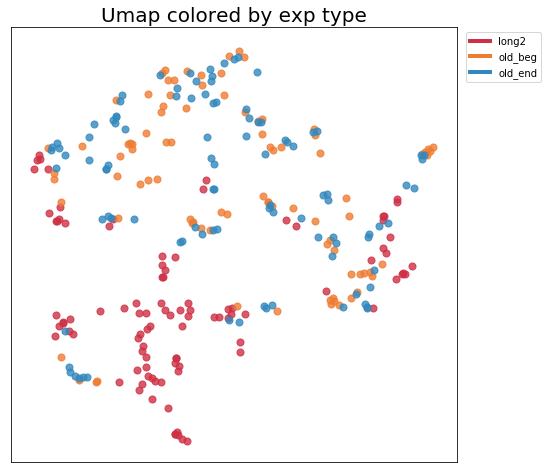

In [107]:
# plot
# prepare colors for plot
phasec = ['#CE3045','#EF7C32','#3288bd']
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(8,8)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by exp type',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.8, s=50)
#fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')